In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
filepath = './AMZN_2006-01-01_to_2018-01-01.csv'
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


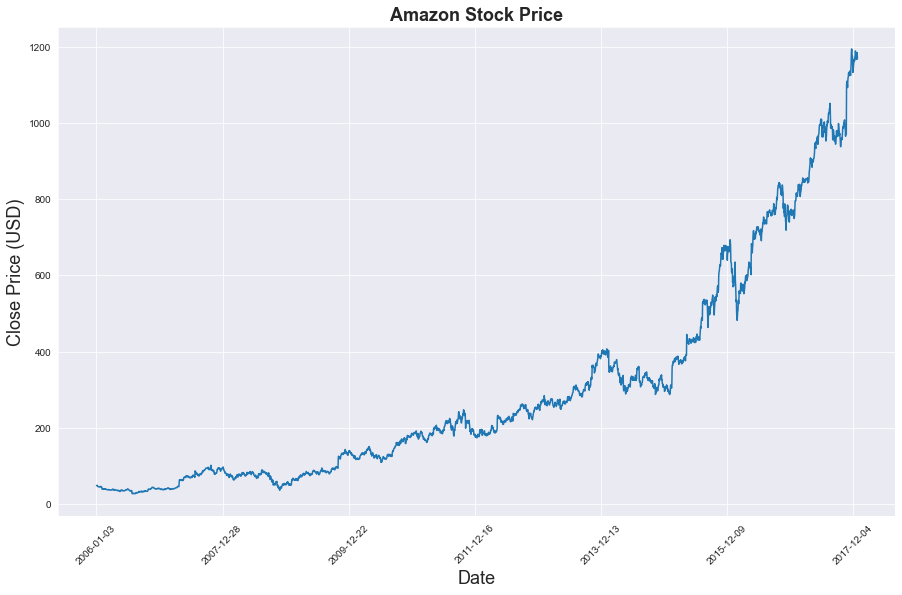

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Amazon Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

## Normalize data

In [7]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3019 entries, 0 to 3018
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3019 non-null   float64
dtypes: float64(1)
memory usage: 47.2 KB


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

C:\Users\a1314\AppData\Local\Temp\ipykernel_20632\68737012.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [9]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [10]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


In [11]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [12]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [14]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.5511150360107422
Epoch  1 MSE:  0.3209425210952759
Epoch  2 MSE:  0.10904042422771454
Epoch  3 MSE:  0.07384619116783142
Epoch  4 MSE:  0.09791064262390137
Epoch  5 MSE:  0.048822637647390366
Epoch  6 MSE:  0.037466879934072495
Epoch  7 MSE:  0.0497627854347229
Epoch  8 MSE:  0.05782296136021614
Epoch  9 MSE:  0.05529562011361122
Epoch  10 MSE:  0.04696528613567352
Epoch  11 MSE:  0.03908585011959076
Epoch  12 MSE:  0.03575391322374344
Epoch  13 MSE:  0.03746286779642105
Epoch  14 MSE:  0.04132235422730446
Epoch  15 MSE:  0.043484993278980255
Epoch  16 MSE:  0.042313992977142334
Epoch  17 MSE:  0.039071615785360336
Epoch  18 MSE:  0.0360502228140831
Epoch  19 MSE:  0.034683432430028915
Epoch  20 MSE:  0.0350060760974884
Epoch  21 MSE:  0.03614795580506325
Epoch  22 MSE:  0.037078987807035446
Epoch  23 MSE:  0.03713144361972809
Epoch  24 MSE:  0.03619343414902687
Epoch  25 MSE:  0.03464074432849884
Epoch  26 MSE:  0.03310132399201393
Epoch  27 MSE:  0.03213541582226753


In [16]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

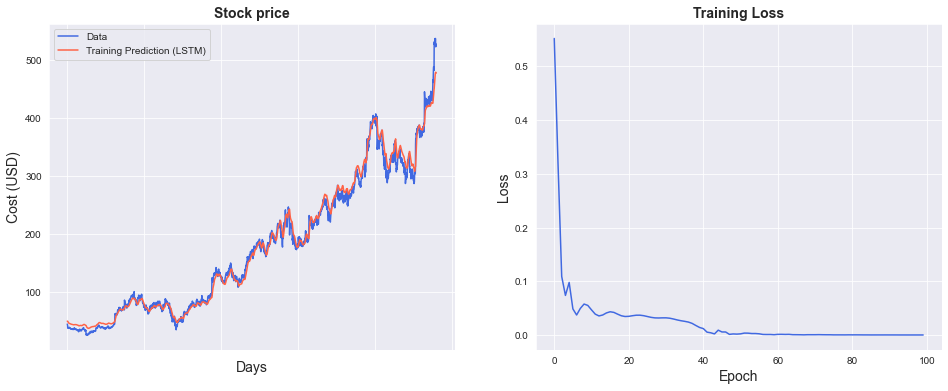

In [17]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [18]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 11.42 RMSE
Test Score: 273.73 RMSE


In [19]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [20]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [21]:
#!pip install chart-studio

In [22]:
!pip show  onnx-simplifier 

Name: onnx-simplifier
Version: 0.4.10
Summary: Simplify your ONNX model
Home-page: https://github.com/daquexian/onnx-simplifier
Author: ONNX Simplifier Authors
Author-email: daquexian566@gmail.com
License: Apache License v2.0
Location: c:\users\a1314\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages
Requires: onnx, rich
Required-by: 


In [23]:
!pip show onnx
!pip show onnxruntime

Name: onnx
Version: 1.13.0
Summary: Open Neural Network Exchange
Home-page: https://github.com/onnx/onnx
Author: ONNX
Author-email: onnx-technical-discuss@lists.lfaidata.foundation
License: Apache License v2.0
Location: c:\users\a1314\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages
Requires: numpy, protobuf, typing-extensions
Required-by: onnx-simplifier


Name: onnxruntime
Version: 1.13.1
Summary: ONNX Runtime is a runtime accelerator for Machine Learning models
Home-page: https://onnxruntime.ai
Author: Microsoft Corporation
Author-email: onnxruntime@microsoft.com
License: MIT License
Location: c:\users\a1314\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages
Requires: coloredlogs, flatbuffers, numpy, packaging, protobuf, sympy
Required-by: 


In [24]:
import onnxruntime
hx = torch.randn(3, 20)

In [25]:
model.eval()
onnx_input = x_test[:1, ] 
torch.onnx.export(model,onnx_input, 'gru.onnx',
input_names=['input','hx'], output_names=['out']
)

C:\Users\a1314\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\onnx\symbolic_opset9.py:4315: UserWarning:

Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 

C:\Users\a1314\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\onnx\_internal\jit_utils.py:258: UserWarning:

The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at ..\torch\csrc\jit\passes\onnx\shape_type_inference.cpp:1888.)

C:\Users\a1314\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n

In [26]:
!python -m onnxsim ./gru.onnx ./gru_simplify.onnx

Simplifying...
Finish! Here is the difference:
┌────────────┬────────────────┬──────────────────┐
│            │ Original Model │ Simplified Model │
├────────────┼────────────────┼──────────────────┤
│ Concat     │ 4              │ 0                │
│ Constant   │ 23             │ 0                │
│ Expand     │ 4              │ 0                │
│ Gather     │ 5              │ 1                │
│ Gemm       │ 1              │ 1                │
│ LSTM       │ 2              │ 2                │
│ Shape      │ 4              │ 0                │
│ Squeeze    │ 2              │ 2                │
│ Transpose  │ 2              │ 2                │
│ Unsqueeze  │ 4              │ 0                │
│ Model Size │ 56.2KiB        │ 52.7KiB          │
└────────────┴────────────────┴──────────────────┘


In [27]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [28]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [29]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.36231130361557007
Epoch  1 MSE:  0.10545411705970764
Epoch  2 MSE:  0.050343289971351624
Epoch  3 MSE:  0.0889730229973793
Epoch  4 MSE:  0.03919965773820877
Epoch  5 MSE:  0.03433254361152649
Epoch  6 MSE:  0.050829753279685974
Epoch  7 MSE:  0.05351709574460983
Epoch  8 MSE:  0.04155697301030159
Epoch  9 MSE:  0.027702849358320236
Epoch  10 MSE:  0.023670224472880363
Epoch  11 MSE:  0.03042619302868843
Epoch  12 MSE:  0.03401963412761688
Epoch  13 MSE:  0.026671944186091423
Epoch  14 MSE:  0.017663508653640747
Epoch  15 MSE:  0.015686171129345894
Epoch  16 MSE:  0.019013676792383194
Epoch  17 MSE:  0.020183276385068893
Epoch  18 MSE:  0.015314368531107903
Epoch  19 MSE:  0.008281150832772255
Epoch  20 MSE:  0.00650073541328311
Epoch  21 MSE:  0.010114974342286587
Epoch  22 MSE:  0.008402214385569096
Epoch  23 MSE:  0.0018095357809215784
Epoch  24 MSE:  0.0021154051646590233
Epoch  25 MSE:  0.00643963972106576
Epoch  26 MSE:  0.0032583323772996664
Epoch  27 MSE:  0.00

In [30]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

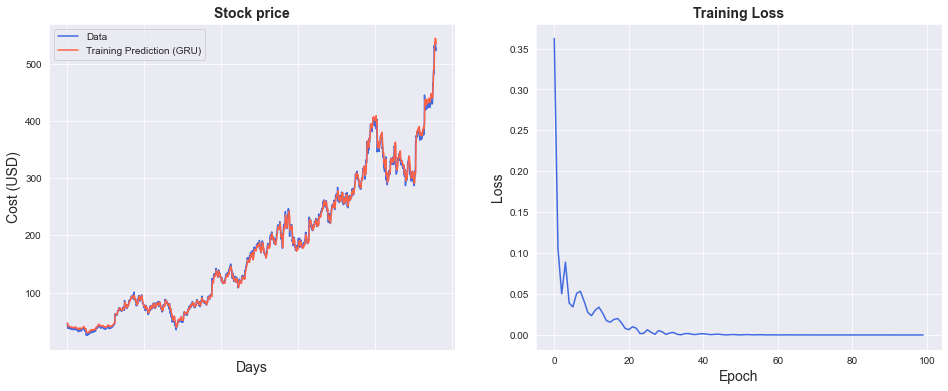

In [31]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [32]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 5.53 RMSE
Test Score: 37.23 RMSE


In [33]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [34]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [35]:
lstm = pd.DataFrame(lstm, columns=['LSTM'])
gru = pd.DataFrame(gru, columns=['GRU'])
result = pd.concat([lstm, gru], axis=1, join='inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result

,LSTM,GRU
Train RMSE,11.416307,5.529507
Test RMSE,273.726697,37.226954
Train Time,17.837047,15.030946
